## Import all required libs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy

warnings.filterwarnings(action="ignore")
pd.set_option('display.max_columns', None)

## Load Data Frame

In [4]:
loan_df = pd.read_csv("loan.csv")

## Data cleanup

#### Drop empty columns
Columns which doesn't have any data

In [7]:
loan_df.dropna(axis=1, how="all", inplace=True)

#### Drop columns having only single value
These columns doesn't contribute much in categorial analysis or compoutation

In [9]:
single_val_list=[column for column in loan_df.columns if loan_df[column].value_counts().size == 1]
single_val_list

['pymnt_plan',
 'initial_list_status',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens']

In [10]:
loan_df.drop(single_val_list, axis=1, inplace=True)
loan_df.shape

(39717, 48)

#### Drop columns having all unique values
These columns doesn't contribute much in categorial analysis or compoutation as all are unique values

In [12]:
alluniq_val_list=[column for column in loan_df.columns if loan_df[column].unique().size == loan_df.index.size]
alluniq_val_list

['id', 'member_id', 'url']

In [13]:
loan_df.drop(alluniq_val_list, axis=1, inplace=True)
loan_df.shape

(39717, 45)

#### Check for duplicate data

In [15]:
loan_df[loan_df.duplicated()].size

0

#### Drop columns having high number of unique values or containing description related data
loan_df.nunique() gives result of all unique values present in each column

In [17]:
loan_df.drop(["mths_since_last_delinq","mths_since_last_record","next_pymnt_d","desc","title","emp_title"],
             axis=1, inplace=True)

#### Drop post loan application columns
There are few columns which will not be present when user is applying for loan

In [19]:
loan_df.drop(["funded_amnt","funded_amnt_inv","last_credit_pull_d","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","last_pymnt_d","last_pymnt_amnt","pub_rec_bankruptcies","total_rec_late_fee","recoveries","collection_recovery_fee"], axis=1, inplace=True)

In [20]:
loan_df.shape

(39717, 24)

## Data manipulation and conversion to correct data types

#### Data manipulation
1. "term" column contains int data along with "month" interpretation -> convert to int
2. "int_rate" contains "%" -> convert to int
3. "revol_util" contains both types float as well as string along with "%" -> convert to float
4. "home_ownership" has "OTHER" and "NONE" both values where none can be replaced by other

In [22]:
loan_df["term"] = loan_df.term.apply(lambda x : int(x.replace("months","").strip()))

In [23]:
loan_df["int_rate"] = loan_df.int_rate.apply(lambda x : float(x.strip("%")))

In [24]:
loan_df["revol_util"] = loan_df.revol_util.astype("str").apply(lambda x : float(x.strip("%").strip()))

In [25]:
loan_df.home_ownership.replace("NONE","OTHER", inplace=True)

In [26]:
(loan_df.isna().sum()/loan_df.index.size)*100

loan_amnt              0.000000
term                   0.000000
int_rate               0.000000
installment            0.000000
grade                  0.000000
sub_grade              0.000000
emp_length             2.706650
home_ownership         0.000000
annual_inc             0.000000
verification_status    0.000000
issue_d                0.000000
loan_status            0.000000
purpose                0.000000
zip_code               0.000000
addr_state             0.000000
dti                    0.000000
delinq_2yrs            0.000000
earliest_cr_line       0.000000
inq_last_6mths         0.000000
open_acc               0.000000
pub_rec                0.000000
revol_bal              0.000000
revol_util             0.125891
total_acc              0.000000
dtype: float64

#### Imputing or removing rows
1. emp_length can be imputed as mode value is highly counted which is having more than 8k records
2. revol_util rows can be dropped as there is no mode value with significant high count
3. "emp_length" contains "<", "years", "year", "+" string

In [28]:
loan_df.emp_length.fillna(loan_df.emp_length.mode()[0], inplace = True)
loan_df.emp_length.isna().sum()

0

In [29]:
loan_df.dropna(axis = 0, subset = ['revol_util'] , inplace = True)
loan_df.revol_util.isna().sum()

0

In [30]:
loan_df["emp_length"] = loan_df.emp_length.astype("str").apply(lambda x : int(x.replace("< 1","0").replace("+","").replace("years","").replace("year","").strip()))

#### Correct data type
1. issue_d to datetime
2. earliest_cr_line to datetime
3. loan amount as float

In [32]:
loan_df["issue_d"] = pd.to_datetime(loan_df.issue_d, format="%b-%y")

In [33]:
loan_df["earliest_cr_line"] = pd.to_datetime(loan_df.earliest_cr_line, format="%b-%y")

In [34]:
loan_df["loan_amnt"] = loan_df.loan_amnt.astype("float")

## Data Filtering and deriving required columns

Analysis can be performed only either on charged or fully paid scenarios and not on active (not completed) loans

In [36]:
loan_filt = loan_df[loan_df.loan_status != "Current"]

<Axes: >

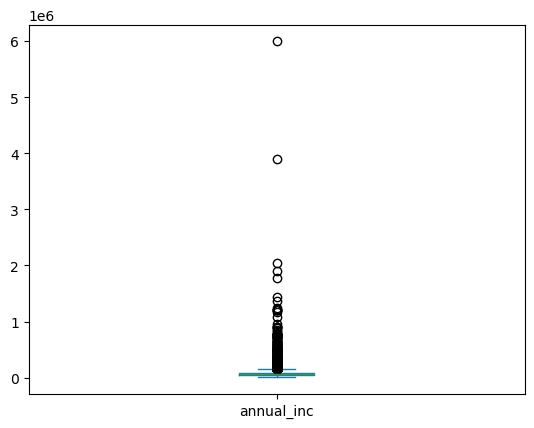

In [37]:
loan_filt.annual_inc.plot.box()

#### Finding outliers and filtering out from data
As less number of outliers can manipulate data a lot. Ignoring them won't impact the result much. High range of annual income we can ingore

<Axes: >

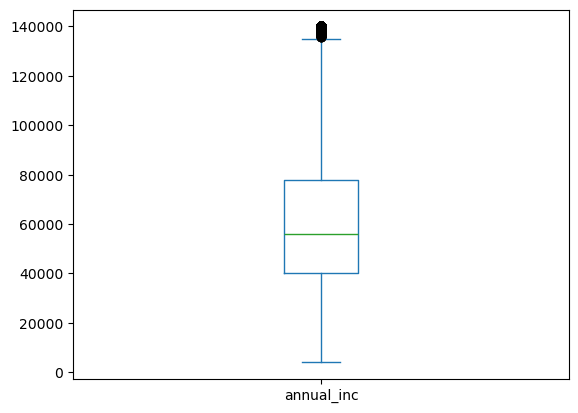

In [39]:
loan_filt=loan_filt[loan_filt.annual_inc <= loan_filt.annual_inc.quantile(0.95)]
loan_filt.annual_inc.plot.box()

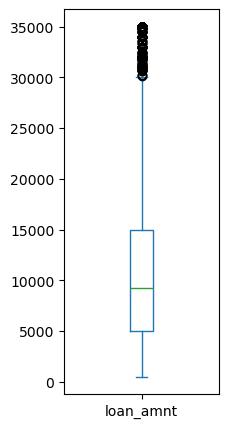

In [40]:
plt.figure(figsize=(2,5))
loan_filt.loan_amnt.plot.box()
plt.show()

#### Add derived columns for further analysis and create categories
1. Interest rate is varying from 5% to 25%, We can create category with 4 bins equally divided which can show us which category having highest impact
2. Number of installments, annual income, loan amount also having good amonut of unique values. Creating bins can help identify category based impact.
3. We can extract year and month from existing data to create derived variables which can help in time series analysis

In [42]:
loan_filt["int_rate_category"]=pd.cut(loan_filt.int_rate, bins=[5,10,15,20,25],precision =0,
                                       labels=['5-10%','10-15%', "15-20%","20-25%"])

loan_filt["installment_category"]=pd.cut(loan_filt.installment, bins=np.arange(0, 1600, 200),
                                       precision =0,labels=['0-0.2k','0.2-0.4k','0.4-0.6k','0.6-0.8k','0.8-1.0k','1.0-1.2k','1.2-1.4k'])

loan_filt["annual_inc_category"]=pd.cut(loan_filt.annual_inc, bins=8,precision =0,
                                       labels=['4k-21k','21k-38k','38k-55k','55k-72k',"72k-89k","89k-106k","106k-123k","123k-140k"])

loan_filt["loan_amnt_category"]=pd.cut(loan_filt.loan_amnt,
                                       bins=np.arange(0, loan_filt.loan_amnt.max()*6/5, step=loan_filt.loan_amnt.max()/5),
                                       precision =0,labels=['0-7k', '7-14k', '14-21k', '21-28k', '28-35k'])

loan_filt["issue_year"]=loan_filt.issue_d.dt.year

loan_filt["issue_month"]=loan_filt.issue_d.dt.month

#### Create new DF for charged off cased as will be used at multiple places

In [44]:
charged_loan_filt = loan_filt[loan_filt.loan_status=="Charged Off"]

In [45]:
loan_filt.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,int_rate_category,installment_category,annual_inc_category,loan_amnt_category,issue_year,issue_month
0,5000.0,36,10.65,162.87,B,B2,10,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,860xx,AZ,27.65,0,1985-01-01,1,3,0,13648,83.7,9,10-15%,0-0.2k,21k-38k,0-7k,2011,12
1,2500.0,60,15.27,59.83,C,C4,0,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,309xx,GA,1.00,0,1999-04-01,5,3,0,1687,9.4,4,15-20%,0-0.2k,21k-38k,0-7k,2011,12
2,2400.0,36,15.96,84.33,C,C5,10,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,606xx,IL,8.72,0,2001-11-01,2,2,0,2956,98.5,10,15-20%,0-0.2k,4k-21k,0-7k,2011,12
3,10000.0,36,13.49,339.31,C,C1,10,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,917xx,CA,20.00,0,1996-02-01,1,10,0,5598,21.0,37,10-15%,0.2-0.4k,38k-55k,7-14k,2011,12
5,5000.0,36,7.90,156.46,A,A4,3,RENT,36000.0,Source Verified,2011-12-01,Fully Paid,wedding,852xx,AZ,11.20,0,2004-11-01,3,9,0,7963,28.3,12,5-10%,0-0.2k,21k-38k,0-7k,2011,12


### Meaning of useful variables

1. 

## Univariate Analysis
Univariate analysis gives variables which contributes to defaulting of loans maximum number of times

#### Analyzing loan status
We need to get feel of data how much are paid against charged off

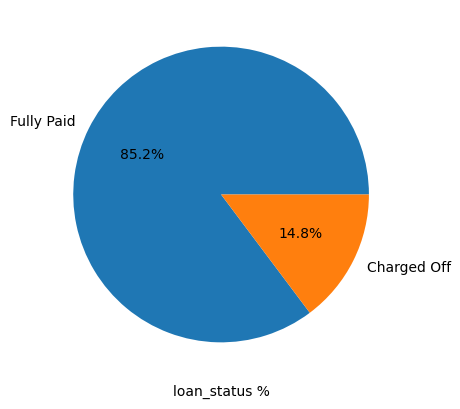

In [49]:
lnstatus_val_count=loan_filt.loan_status.value_counts()
plt.pie(lnstatus_val_count,autopct='%1.1f%%', labels=lnstatus_val_count.index)
plt.xlabel("loan_status %")
plt.show()

#### Analyzing grade for charged off loans
While assigning grade by LC, which could have more number of charged off scenarios. Grade depends on applicant's profile and history.

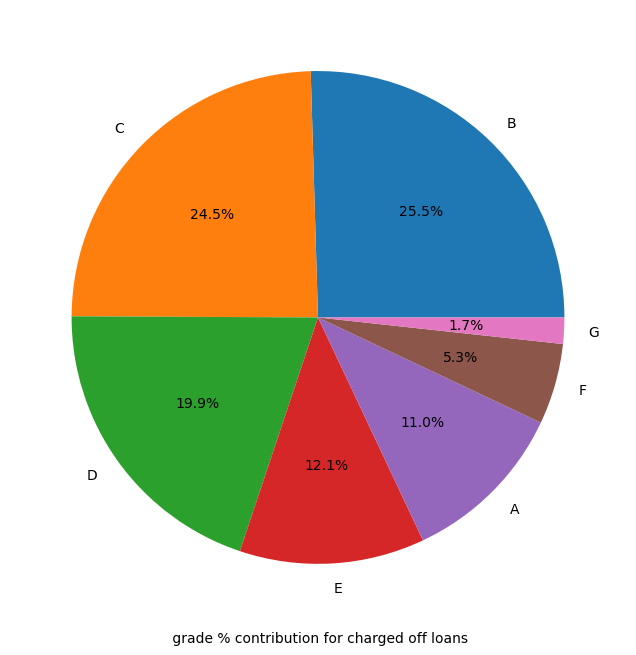

In [51]:
plt.figure(figsize=(8, 8))
grade_val_counts=charged_loan_filt.grade.value_counts()
plt.pie(grade_val_counts, autopct='%1.1f%%', labels=grade_val_counts.index)
plt.xlabel(" grade % contribution for charged off loans")
plt.show()

#### Analyzing verification status for charged off loans
Verification of loan application impact on loan defaulting

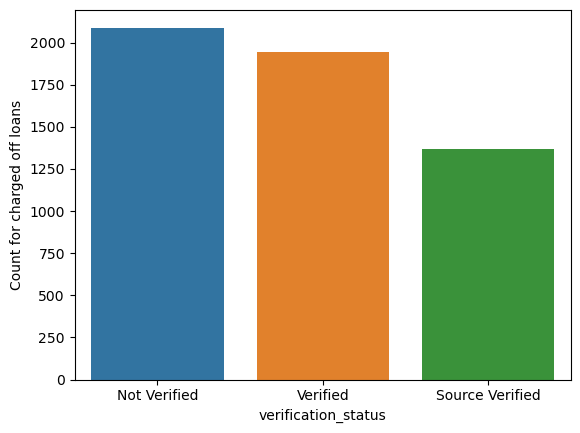

In [53]:
sns.countplot(x=charged_loan_filt.verification_status, data=charged_loan_filt,
              order=charged_loan_filt.verification_status.value_counts().index)
plt.ylabel("Count for charged off loans")
plt.show()

#### Analyzing purpose for charged off loans
What kind of purpose could cause more credit loss. Reason for applying loan also matter.

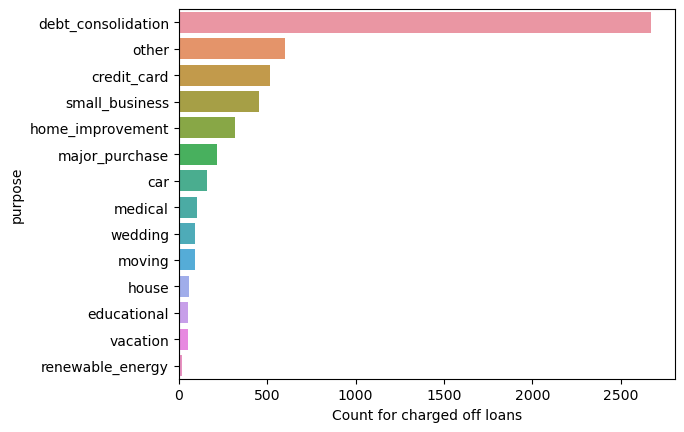

In [55]:
sns.countplot(data=charged_loan_filt, y="purpose", order=charged_loan_filt.purpose.value_counts().index)
plt.xlabel("Count for charged off loans")
plt.show()

#### Analyzing term for charged off loans
Which term has higher number of charged off case. It doesn't give percentage, but can give idea on high impacting category

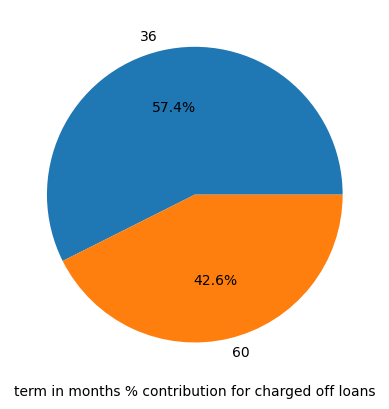

In [57]:
term_val_counts=charged_loan_filt.term.value_counts()
plt.pie(term_val_counts, autopct='%1.1f%%', labels=term_val_counts.index)
plt.xlabel("term in months % contribution for charged off loans")
plt.show()

#### Analyzing home ownersip for charged off loans
Home ownership status by borrower having more impact

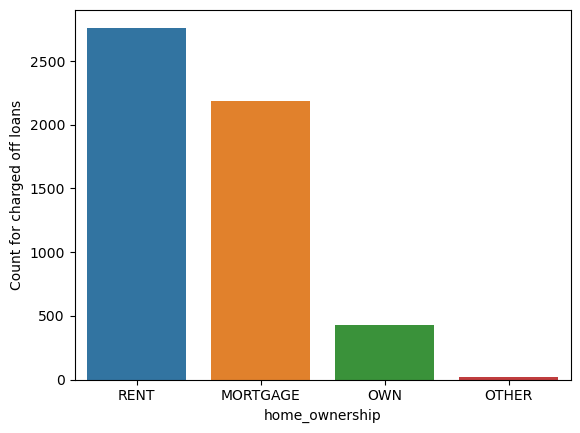

In [59]:
sns.countplot(x='home_ownership', data=charged_loan_filt, order=charged_loan_filt.home_ownership.value_counts().index)
plt.ylabel("Count for charged off loans")
plt.show()

#### Analyzing histogram for loan amount for charged off loans
To identify loan amount category which could contribute more on defaulting.

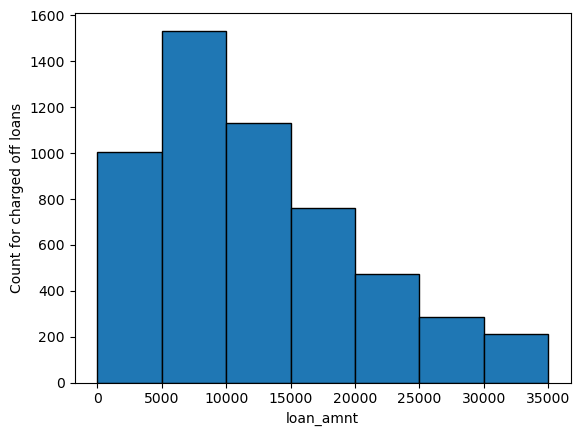

In [61]:
plt.hist(charged_loan_filt["loan_amnt"], bins=7, range=[0,35000], edgecolor='black')
plt.xlabel("loan_amnt")
plt.ylabel("Count for charged off loans")
plt.show()

#### Analyzing int rate categories for charged off loans
To identify which interest rate category can contribute more

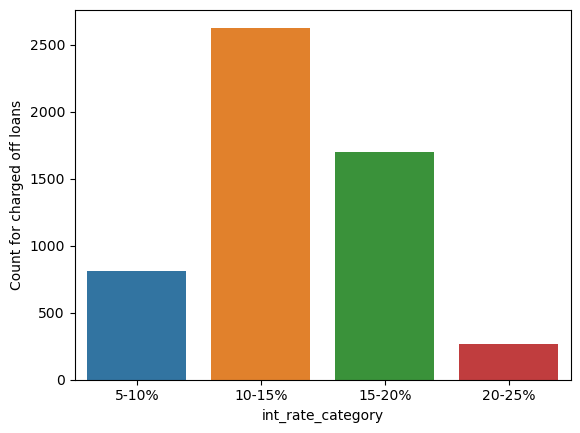

In [63]:
sns.countplot(x='int_rate_category', data=charged_loan_filt)
plt.ylabel("Count for charged off loans")
plt.show()

#### Analyzing annual income for charged off loans
To understand income category which is defaulting loans maximum times

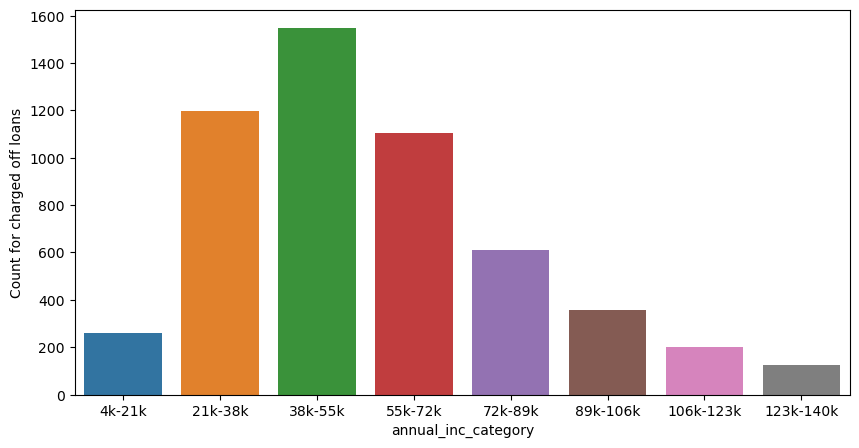

In [65]:
plt.figure(figsize=(10,5))
sns.countplot(x='annual_inc_category', data=charged_loan_filt)
plt.ylabel("Count for charged off loans")
plt.show()

#### Analyzing open account number for charged off loans
To identify impact of open accounts on loan defaulting

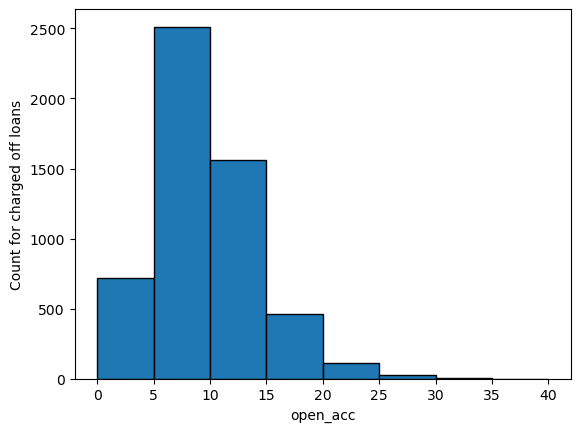

In [67]:
plt.hist(charged_loan_filt['open_acc'],bins=8,range=[0,40],edgecolor='black')
plt.xlabel("open_acc")
plt.ylabel("Count for charged off loans")
plt.show()

#### Analyzing inquiries done in last 6 months for charged off loans
If loans are going to be applied with inquiries or without inquiries

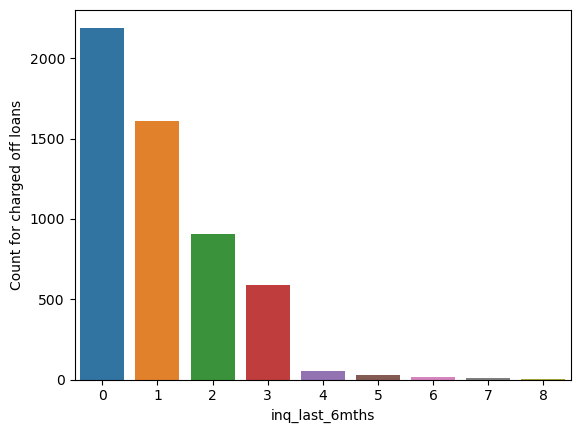

In [69]:
sns.countplot(x='inq_last_6mths', data=charged_loan_filt)
plt.ylabel("Count for charged off loans")
plt.show()

#### Analyzing issue month and year for charged off loans
If any particular month or year having more number of defaulters

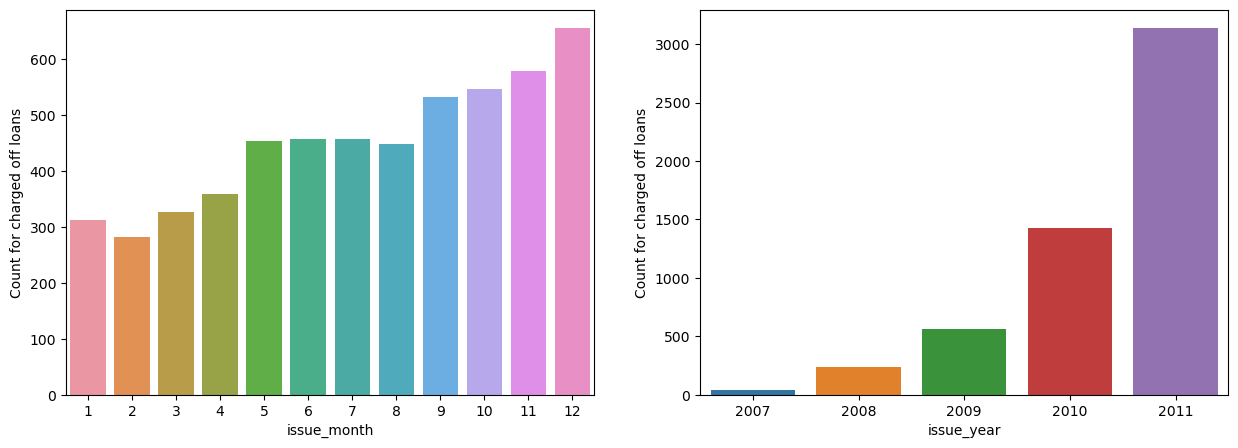

In [71]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(x='issue_month', data=charged_loan_filt)
plt.ylabel("Count for charged off loans")
plt.subplot(122)
sns.countplot(x='issue_year', data=charged_loan_filt)
plt.ylabel("Count for charged off loans")
plt.show()

#### Analyzing top state location for charged off loans
Analyzing if any particular state having more number of defaulters already present

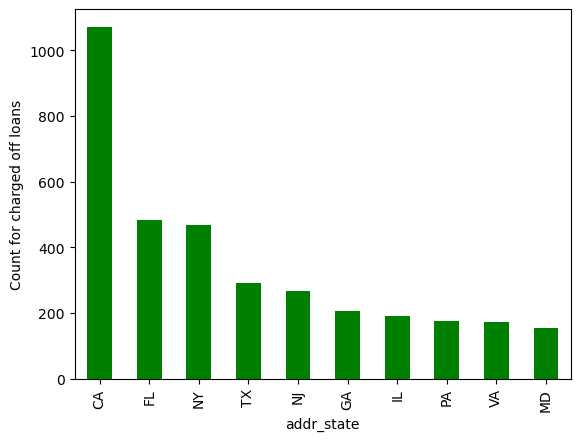

In [73]:
charged_loan_filt.addr_state.value_counts()[:10].plot(kind="bar", color="green")
plt.ylabel("Count for charged off loans")
plt.show()

## Segmented Univariate analysis
Segmented Univariate analysis gives good reults related to probability of defaulting against different categories

#### Analyzing verification status for segments of loan status
Probability of defaulting against verification status category

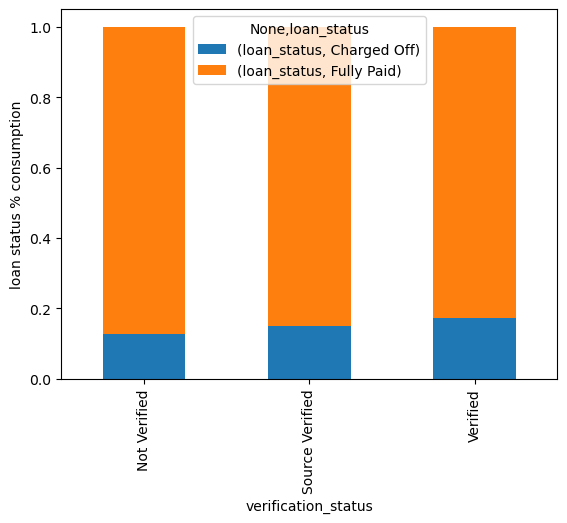

In [76]:
verf_lnstatus_ptb=pd.pivot_table(data=loan_filt, values=loan_filt[["loan_status"]],
                                 index="verification_status", columns=loan_filt.loan_status, aggfunc='count')
verf_lnstatus_ptb.apply(lambda x: x/sum(x), axis=1).plot(kind="bar", stacked=True)
plt.ylabel("loan status % consumption")
plt.show()

#### Analyzing grade for segments of loan status
Probability of defaulting against grade

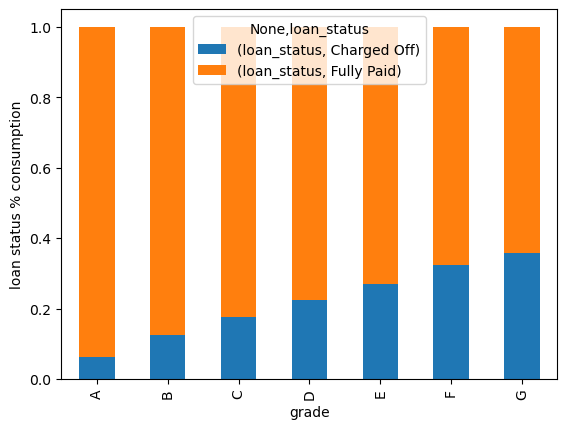

In [78]:
grade_lnstatus_ptb=pd.pivot_table(data=loan_filt, values=loan_filt[["loan_status"]],
                                  index="grade", columns=loan_filt.loan_status, aggfunc='count')
grade_lnstatus_ptb.apply(lambda x: x/sum(x), axis=1).plot(kind="bar", stacked=True)
plt.ylabel("loan status % consumption")
plt.show()

#### Analyzing term for segments of loan status
Probability of defaulting against term in months

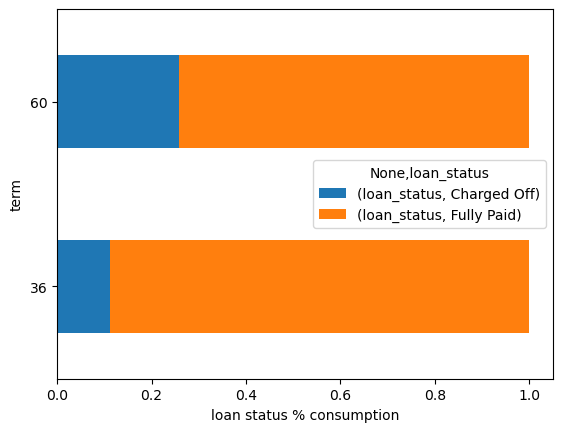

In [80]:
term_lnstatus_ptb=pd.pivot_table(data=loan_filt, values=loan_filt[["loan_status"]],
                                 index="term", columns=loan_filt.loan_status, aggfunc='count')
term_lnstatus_ptb.apply(lambda x: x/sum(x), axis=1).plot(kind="barh", stacked=True)
plt.xlabel("loan status % consumption")
plt.show()

#### Analyzing purpose category for segments of loan status
Probability of defaulting against purpose of loan. Usually risky reasons leads to high probability defaulting of loan application

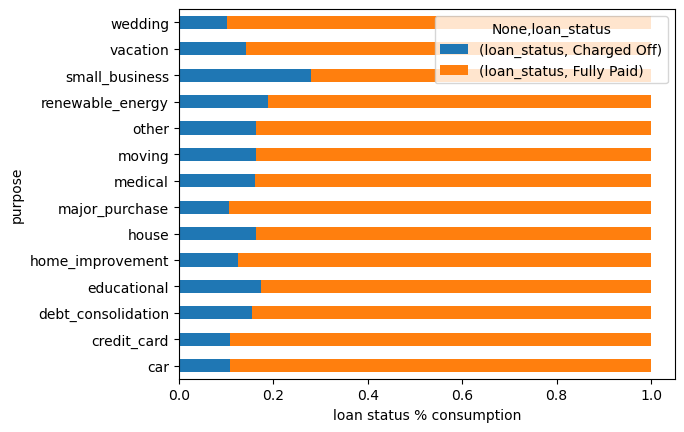

In [82]:
purpose_category_lnstatus_ptb=pd.pivot_table(data=loan_filt, values=loan_filt[["loan_status"]],
                                 index="purpose", columns=loan_filt.loan_status, aggfunc='count')
purpose_category_lnstatus_ptb.apply(lambda x: x/sum(x), axis=1).plot(kind="barh", stacked=True)
plt.xlabel("loan status % consumption")
plt.show()

#### Analyzing interest rate category for segments of loan status
Probability of defaulting against interest rate of loan. Usually higher interest rate leads to high probability defaulting of loan application

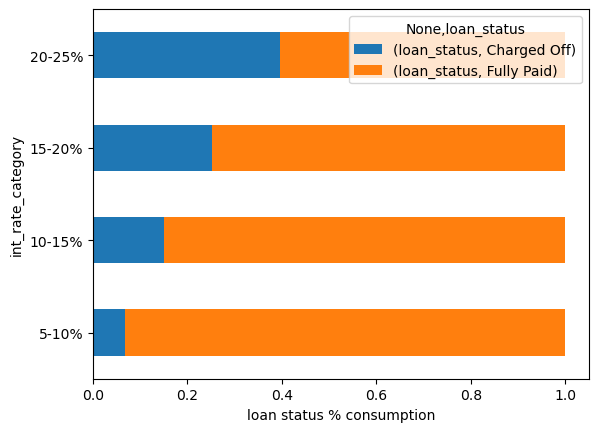

In [84]:
int_rate_category_lnstatus_ptb=pd.pivot_table(data=loan_filt, values=loan_filt[["loan_status"]],
                                 index="int_rate_category", columns=loan_filt.loan_status, aggfunc='count')
int_rate_category_lnstatus_ptb.apply(lambda x: x/sum(x), axis=1).plot(kind="barh", stacked=True)
plt.xlabel("loan status % consumption")
plt.show()

#### Analyzing loan amount category for segments of loan status
As loan amount increases, probability of paying back reduces. Same we can identify in below graph

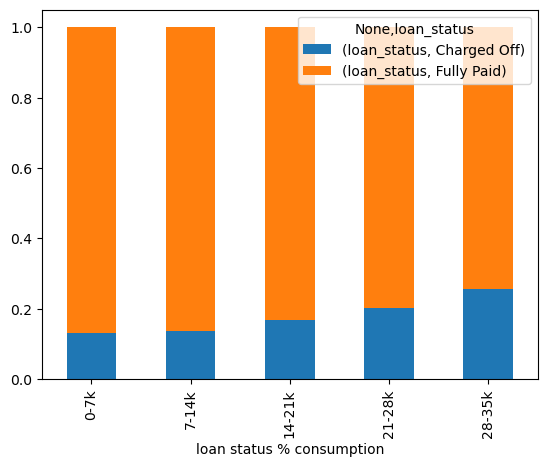

In [86]:
loanamnt_lnstatus_ptb=pd.pivot_table(data=loan_filt, values=loan_filt[["loan_status"]],
                                 index="loan_amnt_category", columns=loan_filt.loan_status, aggfunc='count')
loanamnt_lnstatus_ptb.apply(lambda x: x/sum(x), axis=1).plot(kind="bar", stacked=True)
plt.xlabel("loan status % consumption")
plt.show()

## Bivariate or multi variate analysis
Bivariate analysis gives data points which could contribute maximum losses on average or correlated categories impacting loan payment

#### Analyzing correlation between multiple columns
Correlation helps to identify which categories are highly related to each other. Impact because of one category could make similar impact because of other category if highly correlated.

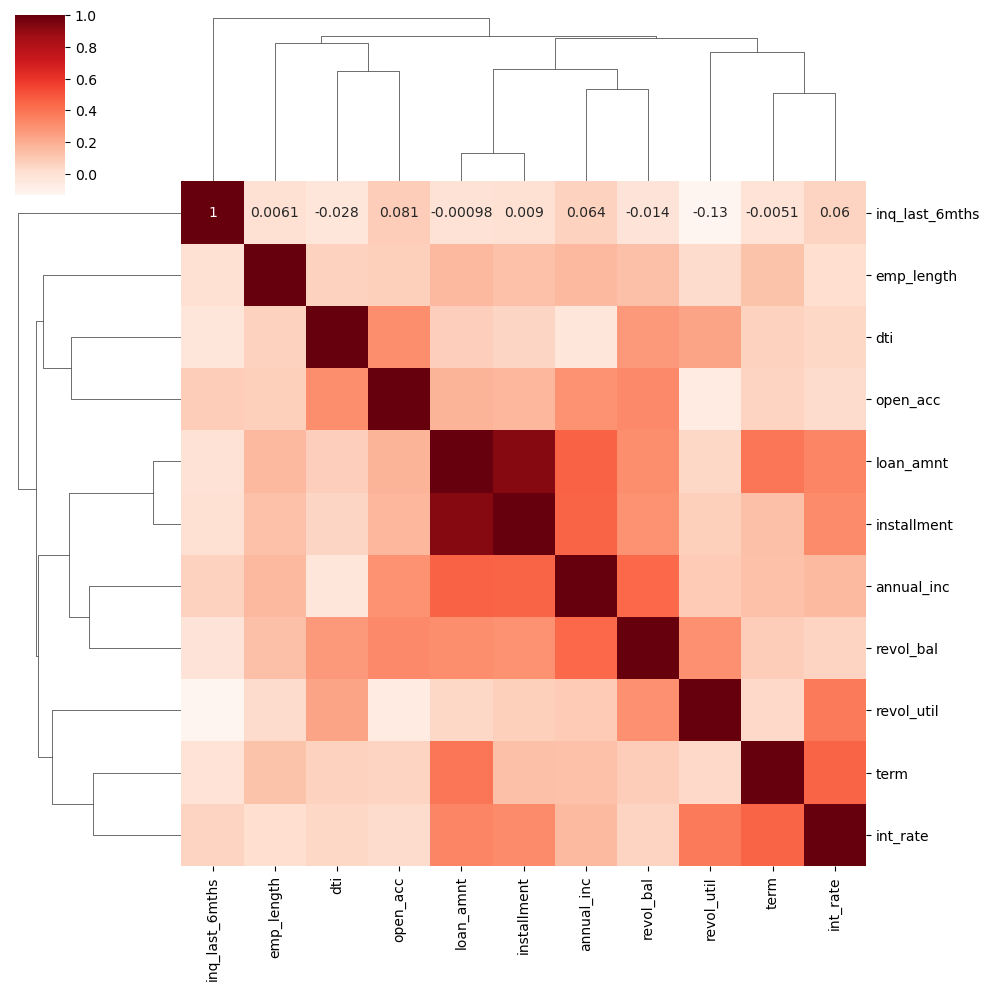

In [89]:

corr_df=charged_loan_filt[["loan_amnt","term","int_rate","installment","emp_length","annual_inc","dti","inq_last_6mths","open_acc","revol_bal","revol_util"]].corr()
sns.clustermap(corr_df, cmap="Reds", annot=True)
plt.show()

#### Analyzing trend between loan amount categories against interest rate for segments of loan status
EMI is highly dependent on loan amount and interest rate. Trying to find relation with these 2 variables for paid or charged off loan status.

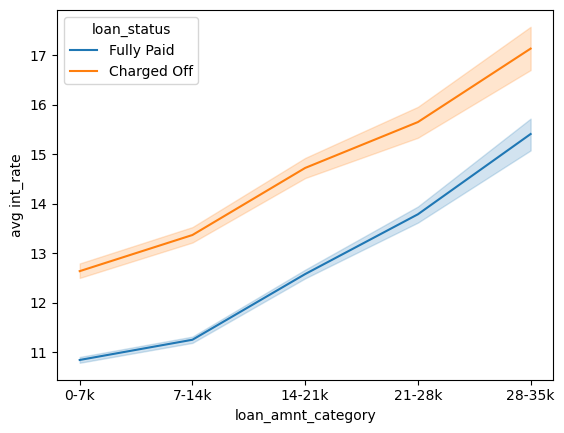

In [91]:
sns.lineplot(data =loan_filt,x='loan_amnt_category', y='int_rate', hue ='loan_status')
plt.ylabel("avg int_rate")
plt.show()

#### Analyzing loan amount against purpose for segments of loan status
Purpose and average amount applied can help identify defaulting cases.

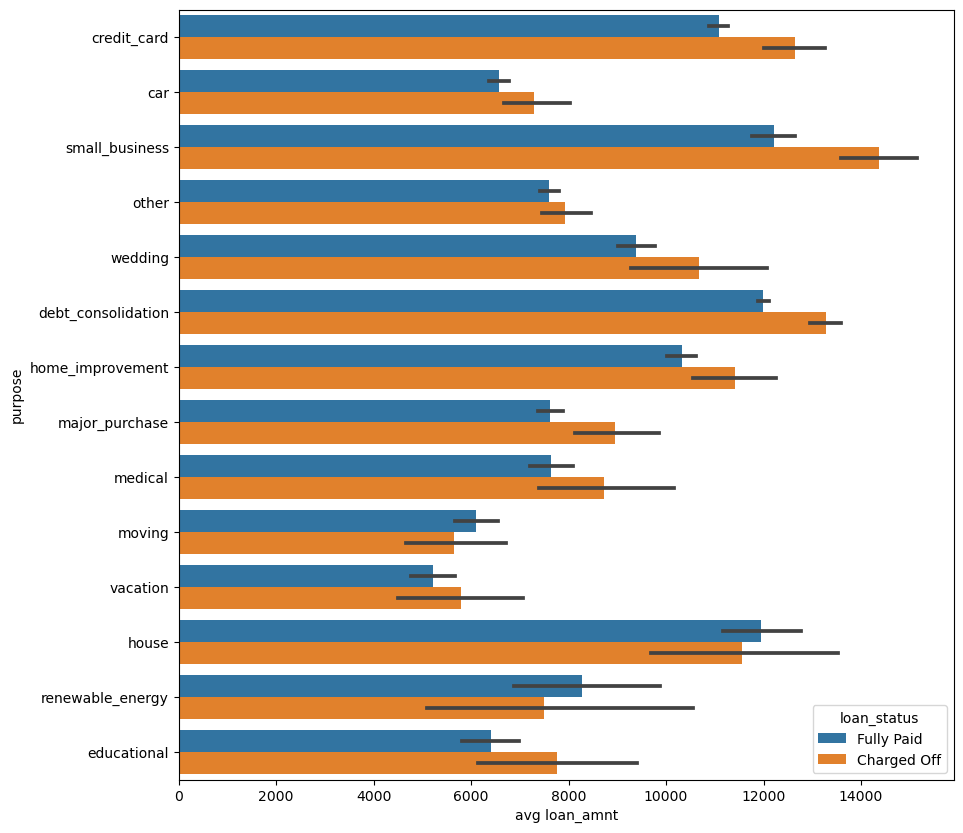

In [93]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_filt,x='loan_amnt', y='purpose', hue ='loan_status')
plt.xlabel("avg loan_amnt")
plt.show()

#### Analyzing loan amount against home ownership for segments of loan status
Home ownership and loan amount applied can give insights on defaulting cases.

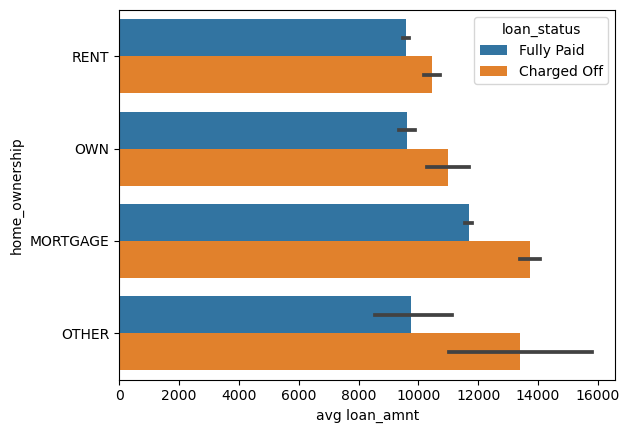

In [95]:
sns.barplot(data =loan_filt,x='loan_amnt', y='home_ownership', hue ='loan_status')
plt.xlabel("avg loan_amnt")
plt.show()

#### Analyzing annual income categories against loan amount average for segments of loan status
Lon affordability can be checked with annual income with loan amount applied

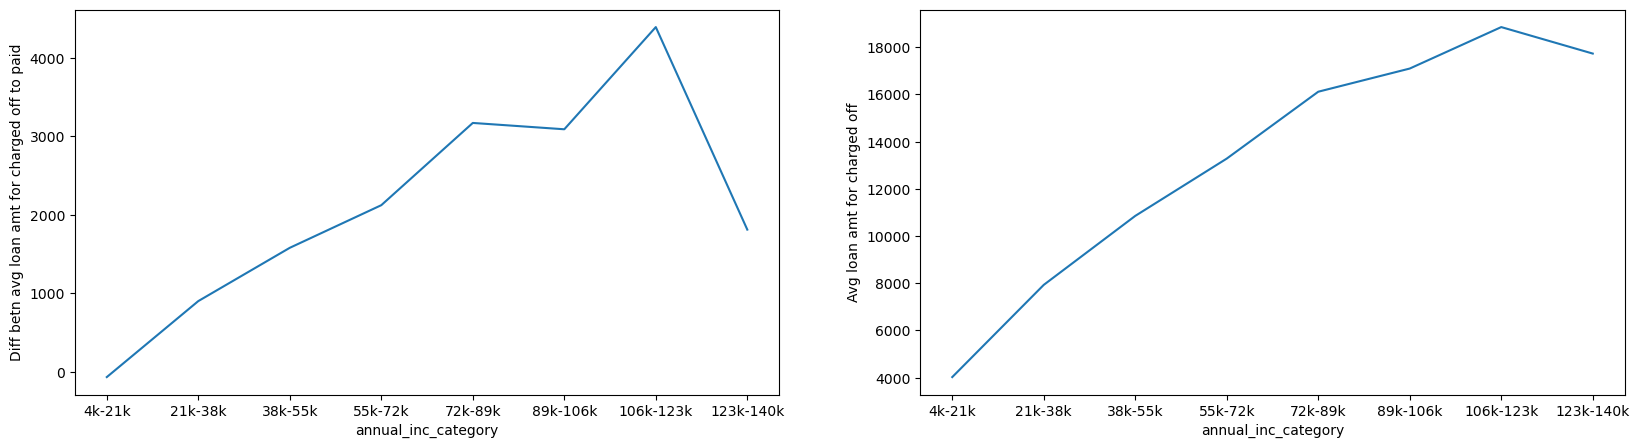

In [97]:
plt.figure(figsize=(20,5))
annualinc_loanamnt_loanst_df = loan_filt.groupby(["annual_inc_category","loan_status"])["loan_amnt"].mean().unstack()
annualinc_loanamnt_loanst_df["diff_avgloanamnt_charged_to_paid"] = annualinc_loanamnt_loanst_df["Charged Off"]-annualinc_loanamnt_loanst_df["Fully Paid"]
plt.subplot(121)
sns.lineplot(annualinc_loanamnt_loanst_df["diff_avgloanamnt_charged_to_paid"])
plt.ylabel("Diff betn avg loan amt for charged off to paid")
plt.subplot(122)
sns.lineplot(annualinc_loanamnt_loanst_df["Charged Off"])
plt.ylabel("Avg loan amt for charged off")
plt.show()

#### Analyzing grade against interest rate average for segments of loan status
Change in interest rate along for different grades can be checked with this analysis

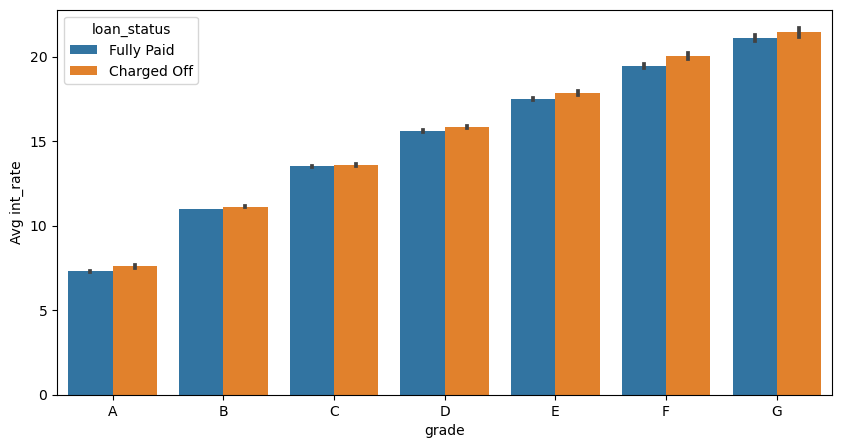

In [99]:
plt.figure(figsize=(10,5))
sns.barplot(data =loan_filt,x='grade', y='int_rate', hue ='loan_status', order=sorted(loan_filt.grade.unique()))
plt.ylabel("Avg int_rate")
plt.show()

#### Analyzing grade against loan amount average for segments of loan status
Applicants with history of payment and new loan application can give insights whether applicant can repay or not

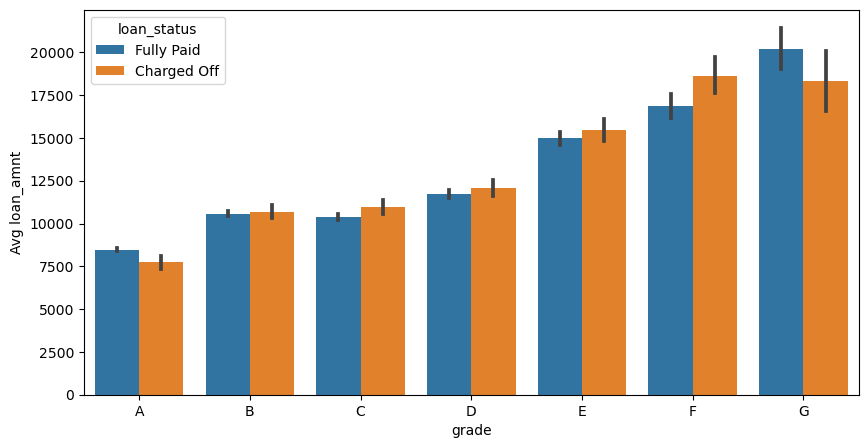

In [101]:
plt.figure(figsize=(10,5))
sns.barplot(data =loan_filt,x='grade', y='loan_amnt', hue ='loan_status', order=sorted(loan_filt.grade.unique()))
plt.ylabel("Avg loan_amnt")
plt.show()

#### Analyzing installment categories against loan amount average for segments of loan status
number of installments alongwith loan amount can help identify if interest paid is high or low. Usually high interest paying loans can cause more probability on defaulting

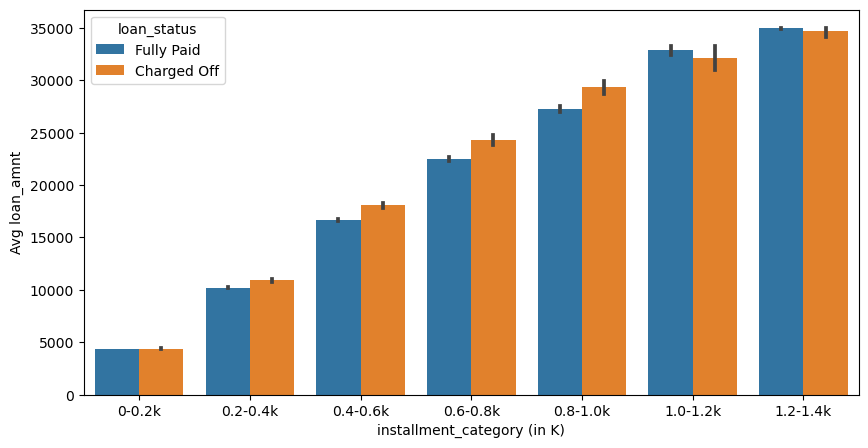

In [103]:
plt.figure(figsize=(10,5))
sns.barplot(data =loan_filt,x='installment_category', y='loan_amnt', hue ='loan_status')
plt.xlabel("installment_category (in K)")
plt.ylabel("Avg loan_amnt")
plt.show()

#### Analyzing cluster for interest rate against loan amount for charged off loans
Loan amount and interest rate probability calculation can help pick particular category which is highly probable on becoming defaulter

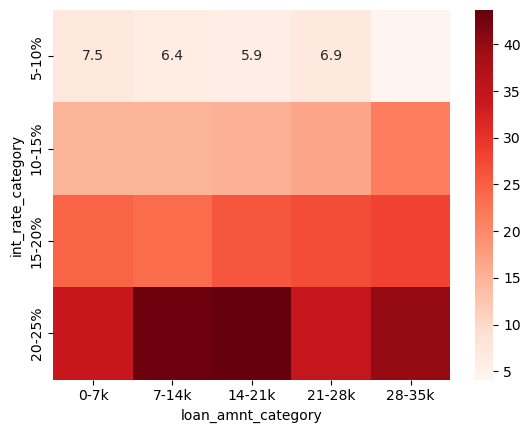

In [105]:
intrate_loanamnt_lnstatus_gb=loan_filt.groupby(["int_rate_category","loan_amnt_category","loan_status"])["loan_status"].count().unstack()
intrate_loanamnt_lnstatus_gb["perc_charged_off"]=intrate_loanamnt_lnstatus_gb["Charged Off"]*100/(intrate_loanamnt_lnstatus_gb["Charged Off"]+intrate_loanamnt_lnstatus_gb["Fully Paid"])
sns.heatmap(intrate_loanamnt_lnstatus_gb.unstack()["perc_charged_off"], cmap="Reds", annot=True)
plt.show()

#### Analyzing average annual income against purpose for segments of loan status
Annual income if high, then chances of not paying reduces even if interest rate is high. Hence income if analyzed with interest rate can give insights if loan will be paid or not

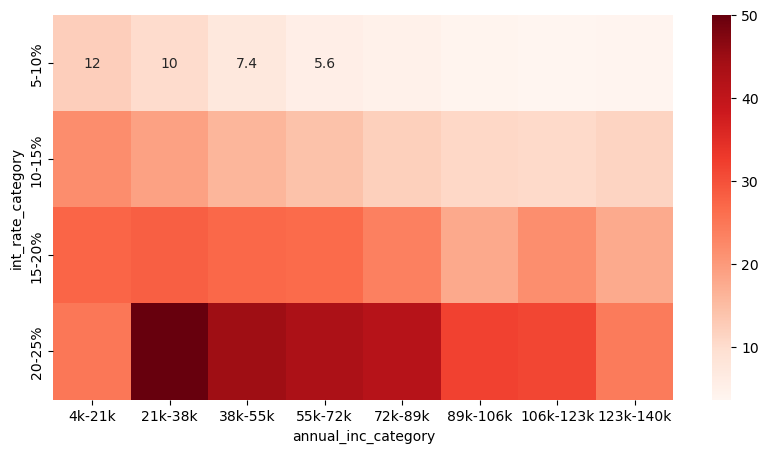

In [107]:
plt.figure(figsize=(10,5))
intrate_annualinc_lnstatus_gb=loan_filt.groupby(["int_rate_category","annual_inc_category","loan_status"])["loan_status"].count().unstack()
intrate_annualinc_lnstatus_gb["perc_charged_off"]=intrate_annualinc_lnstatus_gb["Charged Off"]*100/(intrate_annualinc_lnstatus_gb["Charged Off"]+intrate_annualinc_lnstatus_gb["Fully Paid"])
sns.heatmap(intrate_annualinc_lnstatus_gb.unstack()["perc_charged_off"], cmap="Reds", annot=True)
plt.show()

## Conclusions
The above analysis for loan data on multiple variables gives below data points.

### Univariate analysis
There is **more number** of defaulting loan when:

1.  Grade is "B"
2.  Loan status is "Not verified"
3.  Purpose of taking loan is "Debt consolidation"
4.  term is "36 months"
5.  Home ownership is "Rent"
6.  Loan amount is between 5000 to 10000
7.  Interest rate is between 10% to 15%
8.  Annual income is between 38k to 55k
9.  Number of open accounts is between 5 to 10
10. Number of inquiries in last 6 months is 0
11. Loan if issues in "December"
12. Applicant's state is "CA"

This analysis gives categories where maximum defaulters are present (does not mean necessarily that probability is high or low).

### Segmented analysis
There is a **high probability** of defaulting loan when:

1.  Loan status is "verified"
2.  Grade is "G". As grade decreases, defaulting probability increases.
3.  Term is "60 months". More number of months to repay increases defaulting probability.
4.  Purpose is "Small business". Risky purpose increases probability.
5.  Interest rate category is between 20-25%. If interest rate increases, defaulting chances also increases.
6.  Loan amount is between 28000 to 35000, highest probability of not paying loan. Higher the loan amount more probability of loan defaulting application.

This analysis gives category wise probability which could result in defaulting cases.

### Correlation analysis

Positive correlation for charged off loans
1. cluster of loan amount, installment and annual inc
2. term and interest rate

### Bivariate or multi-variate analysis
There is a **high credit loss risk** of defaulting loan when:

1.  interest rate higher by 2% across all loan amount categories leads to more defaults
2.  purpose as "small business" requiring loan amount of 14k+. Risky purpose with higher loan amount
3.  home ownership as "mortgage" requiring loan amount of 13k+
4.  annual income between 106k to 123k and loan amount of 18k+
5.  grade is "G" and interest rate is above 20%
    1. As grade goes from "A" to "G" Possibility of defaulter increases too and graph shows that interest rate also goes up.
7.  Grade is either F and loan amount is between 17.5k-20k
8.  interest rate is between 20-25% and loan amount between 14000 to 21000
9.  interest rate is between 20-25% and annual income between 21000 to 38000. More interest rate but lesser annual income result in defaulting loan.

This analysis gives special cases which could result in defaulting loan applications